In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.preprocessing import StandardScaler
from statsmodels .tsa . seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg , ar_select_order
from sklearn.metrics import mean_squared_error

In [2]:
info_df = pd.read_excel('/Users/harshams/Downloads/info.xlsx')

In [3]:
info_df

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,...,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,NSRDB,678141,-,-,-,30.29,-97.74,-6,183,-6,...,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,v3.2.2


In [4]:
data_1 = pd.read_csv('/Users/harshams/Downloads/5_Years_Data.csv')

In [5]:
data_1

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2018,1,1,0,30,-3.1,0,0,0,7,...,0,55.32,172.65,0.15,1015,1.1,14,5.3,0.0,0.0
1,2018,1,1,1,30,-3.4,0,0,0,7,...,0,54.33,165.61,0.15,1016,1.2,15,5.2,0.0,0.0
2,2018,1,1,2,30,-3.7,0,0,0,7,...,0,53.25,153.25,0.15,1016,1.2,15,5.0,0.0,0.0
3,2018,1,1,3,30,-4.0,0,0,0,7,...,0,51.90,140.34,0.15,1016,1.2,13,5.0,0.0,0.0
4,2018,1,1,4,30,-4.2,0,0,0,7,...,0,50.17,127.43,0.15,1017,1.2,11,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2022,12,31,19,30,21.6,0,0,0,3,...,0,90.03,112.87,0.15,986,3.7,167,3.1,0.0,0.0
43820,2022,12,31,20,30,21.0,0,0,0,0,...,0,95.94,125.57,0.15,986,3.7,166,3.1,0.0,0.0
43821,2022,12,31,21,30,20.9,0,0,0,0,...,0,98.58,138.46,0.15,985,3.6,167,3.3,0.0,0.0
43822,2022,12,31,22,30,20.9,0,0,0,0,...,0,99.73,151.39,0.15,985,3.6,169,3.6,0.0,0.0


In [6]:
data_1.shape

(43824, 24)

In [7]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Year                                         43824 non-null  int64  
 1   Month                                        43824 non-null  int64  
 2   Day                                          43824 non-null  int64  
 3   Hour                                         43824 non-null  int64  
 4   Minute                                       43824 non-null  int64  
 5   Temperature                                  43824 non-null  float64
 6   Clearsky DHI                                 43824 non-null  int64  
 7   Clearsky DNI                                 43824 non-null  int64  
 8   Clearsky GHI                                 43824 non-null  int64  
 9   Cloud Type                                   43824 non-null  int64  
 10

In [8]:
data_1[data_1.duplicated()]

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)


In [9]:
data_1[data_1.isnull().sum(axis=1)==1]

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)


In [10]:
import numpy as np

def find_outliers_tukey ( x):
    q1 = np . percentile (x , 25)
    q3 = np . percentile (x , 75)
    iqr = q3 - q1
    floor = q1 - 1.5* iqr
    ceiling = q3 + 1.5* iqr
    outlier_indices = list (x. index [( x < floor ) |( x > ceiling ) ])
    outlier_values = list (x[ outlier_indices ])

    return outlier_indices , outlier_values

In [11]:
tukey_indices , tukey_values = find_outliers_tukey (data_1['GHI'])

In [12]:
tukey_indices

[1548,
 1572,
 1573,
 1692,
 1716,
 1740,
 1741,
 1859,
 1860,
 1883,
 1884,
 1885,
 1908,
 1909,
 1932,
 2029,
 2099,
 2100,
 2101,
 2123,
 2124,
 2125,
 2147,
 2148,
 2243,
 2244,
 2245,
 2268,
 2341,
 2387,
 2388,
 2389,
 2413,
 2437,
 2485,
 2507,
 2508,
 2509,
 2531,
 2532,
 2533,
 2555,
 2556,
 2557,
 2580,
 2581,
 2603,
 2604,
 2605,
 2628,
 2675,
 2676,
 2677,
 2699,
 2700,
 2701,
 2723,
 2724,
 2747,
 2770,
 2771,
 2772,
 2773,
 2774,
 2795,
 2796,
 2819,
 2820,
 2821,
 2843,
 2986,
 2987,
 2988,
 2989,
 3010,
 3011,
 3012,
 3013,
 3014,
 3034,
 3035,
 3036,
 3037,
 3059,
 3083,
 3084,
 3085,
 3106,
 3107,
 3108,
 3109,
 3131,
 3132,
 3133,
 3157,
 3179,
 3180,
 3227,
 3228,
 3251,
 3252,
 3253,
 3275,
 3276,
 3277,
 3298,
 3299,
 3300,
 3301,
 3323,
 3324,
 3396,
 3419,
 3444,
 3445,
 3467,
 3468,
 3469,
 3491,
 3492,
 3493,
 3515,
 3516,
 3517,
 3539,
 3540,
 3541,
 3563,
 3564,
 3565,
 3587,
 3588,
 3589,
 3611,
 3612,
 3613,
 3635,
 3636,
 3637,
 3659,
 3660,
 3661,
 3683,

In [13]:
tukey_values

[911,
 920,
 896,
 922,
 909,
 926,
 900,
 916,
 963,
 918,
 966,
 939,
 916,
 914,
 926,
 901,
 937,
 980,
 950,
 926,
 968,
 938,
 897,
 963,
 934,
 977,
 942,
 906,
 941,
 956,
 995,
 962,
 924,
 928,
 993,
 998,
 1033,
 994,
 983,
 1022,
 988,
 968,
 1003,
 966,
 973,
 943,
 973,
 1014,
 978,
 927,
 987,
 1020,
 983,
 985,
 1020,
 985,
 971,
 907,
 952,
 907,
 1010,
 1045,
 1005,
 896,
 948,
 918,
 987,
 1020,
 975,
 942,
 902,
 998,
 1029,
 991,
 909,
 1005,
 1038,
 1001,
 899,
 899,
 927,
 1002,
 985,
 912,
 985,
 1014,
 975,
 903,
 997,
 1024,
 987,
 1001,
 1006,
 995,
 946,
 941,
 939,
 957,
 991,
 967,
 999,
 964,
 978,
 1009,
 974,
 898,
 991,
 1022,
 942,
 925,
 931,
 993,
 973,
 994,
 961,
 968,
 1000,
 968,
 965,
 996,
 964,
 975,
 1009,
 960,
 987,
 1015,
 982,
 973,
 1007,
 974,
 980,
 1009,
 975,
 969,
 1006,
 972,
 966,
 992,
 958,
 963,
 995,
 960,
 925,
 969,
 942,
 969,
 986,
 973,
 965,
 996,
 964,
 979,
 979,
 937,
 965,
 949,
 960,
 988,
 954,
 937,
 959,
 982,
 

In [14]:
data = data_1[~ data_1.isin(tukey_values)] 
data = data_1[~ data_1.index.isin(tukey_indices)] 
#---------------------
ave=np.mean(data)
std=np.std(data)

In [15]:
ave

188.46704382732844

In [16]:
std

Year                                             1.411769
Month                                            3.495498
Day                                              8.805180
Hour                                             7.045587
Minute                                           0.000000
Temperature                                      9.398525
Clearsky DHI                                    55.315327
Clearsky DNI                                   378.164026
Clearsky GHI                                   312.221894
Cloud Type                                       3.095327
Dew Point                                        8.836647
DHI                                             90.655042
DNI                                            318.546316
Fill Flag                                       17.917881
GHI                                            262.250568
Relative Humidity                               22.968147
Solar Zenith Angle                              39.150197
Surface Albedo

In [17]:
data

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2018,1,1,0,30,-3.1,0,0,0,7,...,0,55.32,172.65,0.15,1015,1.1,14,5.3,0.0,0.0
1,2018,1,1,1,30,-3.4,0,0,0,7,...,0,54.33,165.61,0.15,1016,1.2,15,5.2,0.0,0.0
2,2018,1,1,2,30,-3.7,0,0,0,7,...,0,53.25,153.25,0.15,1016,1.2,15,5.0,0.0,0.0
3,2018,1,1,3,30,-4.0,0,0,0,7,...,0,51.90,140.34,0.15,1016,1.2,13,5.0,0.0,0.0
4,2018,1,1,4,30,-4.2,0,0,0,7,...,0,50.17,127.43,0.15,1017,1.2,11,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2022,12,31,19,30,21.6,0,0,0,3,...,0,90.03,112.87,0.15,986,3.7,167,3.1,0.0,0.0
43820,2022,12,31,20,30,21.0,0,0,0,0,...,0,95.94,125.57,0.15,986,3.7,166,3.1,0.0,0.0
43821,2022,12,31,21,30,20.9,0,0,0,0,...,0,98.58,138.46,0.15,985,3.6,167,3.3,0.0,0.0
43822,2022,12,31,22,30,20.9,0,0,0,0,...,0,99.73,151.39,0.15,985,3.6,169,3.6,0.0,0.0


In [18]:
data_by_day = data.groupby(by=['Month', 'Day'])

In [19]:
allowed_dt = ['monthly', 'daily', 'hourly']

def plot_statistics_over_time(data, feature, dt='monthly', statistics=None):
    data = data.sort_values(by=['Year', 'Month', 'Day', 'Hour', 'Minute'])
    
    if statistics is None:
        statistics = [(np.mean, 'Mean')]

    if dt not in allowed_dt:
        raise ValueError(f"Invalid dt: {dt}. Allowed values: {allowed_dt}")

    group_vals = {
        'monthly': ["Year", "Month"],
        'daily': ["Year", "Month", "Day"],
        'hourly': ["Year", "Month", "Day", "Hour"],
    }
    x_labels = {
        'monthly': "Months",
        'daily': "Days",
        'hourly': "Hours"
    }

    dot_size = {
        'monthly': 10,
        'daily': 5,
        'hourly': 2
    }


    stats = [
        [stat(group[feature]) for __, group in data.groupby(group_vals[dt])]
        for stat, __ in statistics
    ]

    _ = plt.figure(figsize=(20, 10))
    if len(statistics) == 1:
        _ = plt.plot(stats[0], marker='o', ms=dot_size[dt]) 
    else: 
        for s, label in zip(stats, [l for __, l in statistics]):
            _ = plt.plot(s, label=label, marker='o', ms=dot_size[dt])  
        _ = plt.legend(fontsize=18)

    _ = plt.xlabel(x_labels[dt], size=18)  
    if len(statistics) == 1:
        _ = plt.ylabel(f'{feature} ({statistics[0][1]})', size=18) 
    else: 
        _ = plt.ylabel(feature, size=18)

    _ = plt.xticks(size=15)
    _ = plt.yticks(size=15)


    return stats

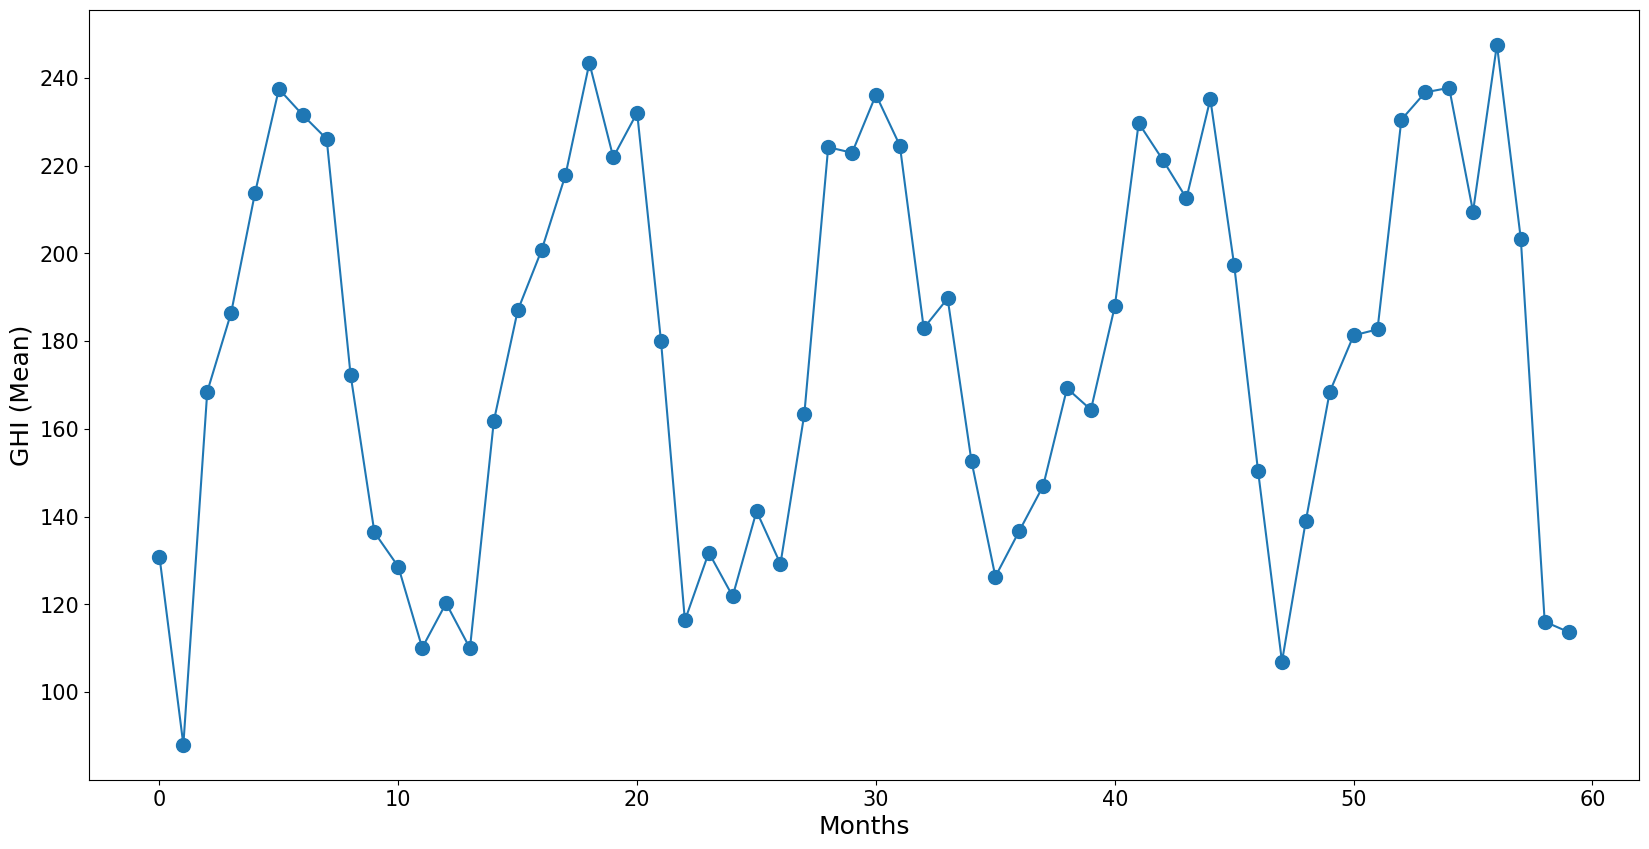

In [20]:
stats = plot_statistics_over_time(data, feature='GHI', dt='monthly')

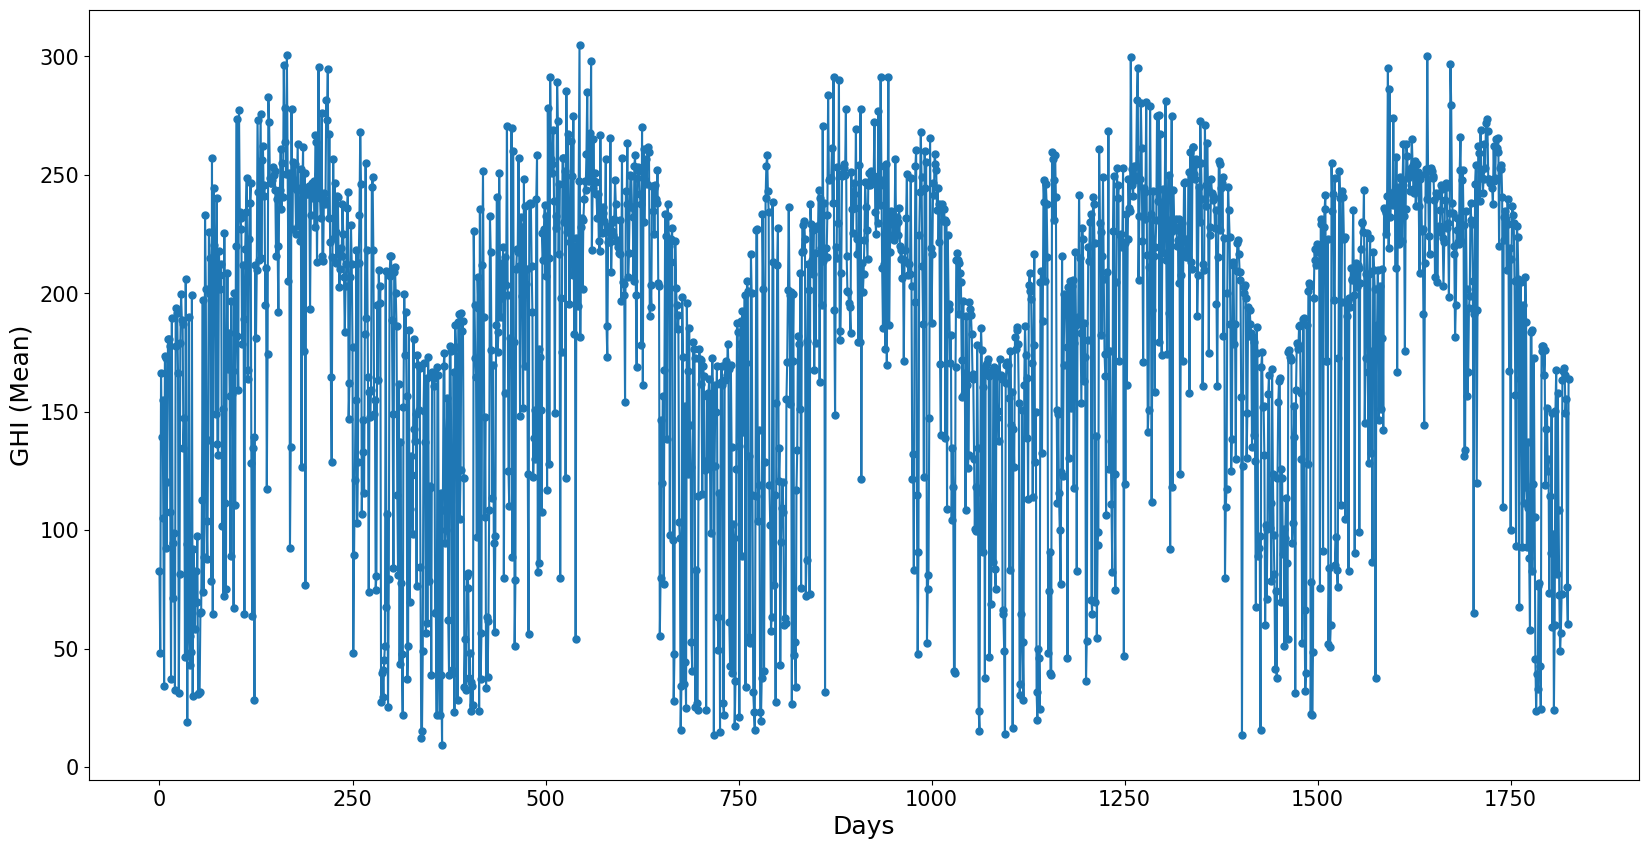

In [21]:
stats = plot_statistics_over_time(data, feature='GHI', dt='daily')

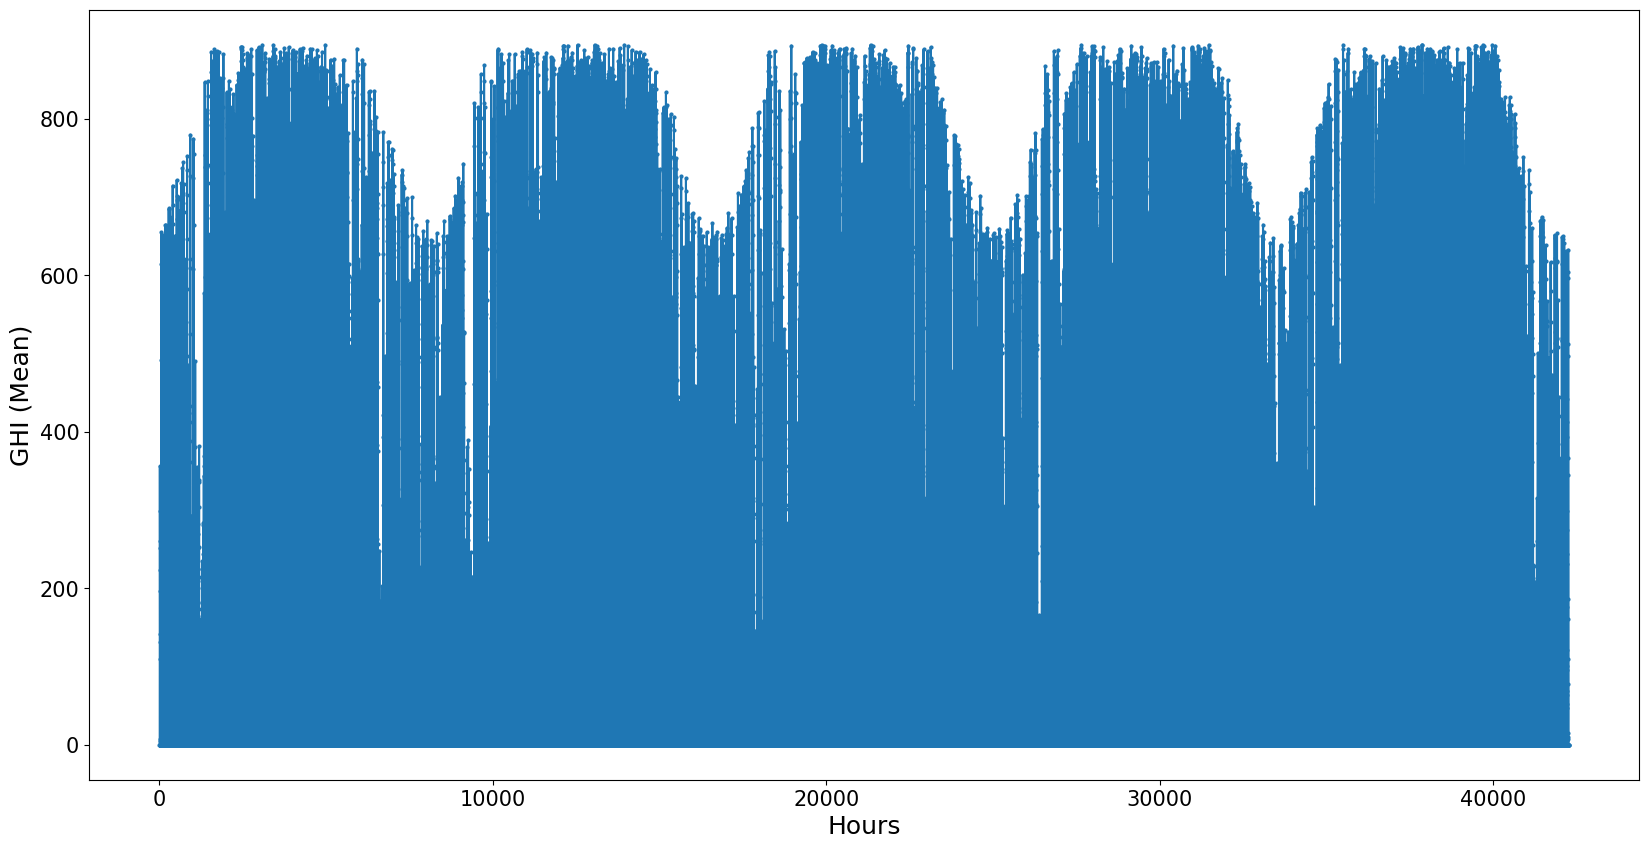

In [22]:
stats = plot_statistics_over_time(data, feature='GHI', dt='hourly')

In [23]:
import statsmodels.formula.api as smf

In [24]:
data.columns = data.columns.str.replace(' ', '_')

In [25]:
lm1 = smf.ols( formula = "GHI ~ Temperature + DHI + DNI + Solar_Zenith_Angle + Pressure + Relative_Humidity", data = data).fit()

In [26]:
lm1.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GHI   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 8.528e+04
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:00:25   Log-Likelihood:            -2.4101e+05
No. Observations:               42271   AIC:                         4.820e+05
Df Residuals:                   42264   BIC:                         4.821e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -800.5019     84.542     -9.469      0.000    -966.206    -634.798
Temperature            1.8643      0.057     32.841      0.000       1.753       1.976
DHI                    1.2235      0.006    195.150      0.000       1.211       1.236
DNI                    0.5718      0.002    340.842      0.000       0.568       0.575
Solar_Zenith_Angle     0.1462      0.018      8.347      0.000       0.112       0.181
Pressure               0.7389      0.084      8.829      0.000       0.575       0.903
Relative_Humidity     -0.0291      0.022     -1.307      0.191      -0.073       0.015
==============================================================================
Omnibus:                     2680.954   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11362.875
Skew:                          -0.158   Prob(JB):                         0.00
Kurtosis:                       5.520   Cond. No.                     2.47e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
from sklearn . linear_model import LinearRegression
from sklearn import metrics
from sklearn . model_selection import train_test_split

In [28]:
X = data[["GHI","DHI", "DNI","Relative_Humidity","Pressure","Temperature"]]

In [29]:
y = data.Month

In [30]:
X_train , X_test , y_train , y_test = train_test_split (X , y , test_size =0.2 , random_state =1)

In [31]:
lm2 = LinearRegression()

In [32]:
lm2.fit(X_train , y_train)

LinearRegression()

In [33]:
y_pred = lm2.predict(X_test)

In [34]:
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

3.3784345641814255


In [35]:
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['Day'].astype(str)
                             + ' ' + data['Hour'].astype(str) + ':' + data['Minute'].astype(str))

/var/folders/d5/kq909x6s3f97prhwg_tzr2hc0000gn/T/ipykernel_52774/3679174708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['Day'].astype(str)


In [36]:
data['Date']

0       2018-01-01 00:30:00
1       2018-01-01 01:30:00
2       2018-01-01 02:30:00
3       2018-01-01 03:30:00
4       2018-01-01 04:30:00
                ...        
43819   2022-12-31 19:30:00
43820   2022-12-31 20:30:00
43821   2022-12-31 21:30:00
43822   2022-12-31 22:30:00
43823   2022-12-31 23:30:00
Name: Date, Length: 42271, dtype: datetime64[ns]

In [37]:
data

,Year,Month,Day,Hour,Minute,Temperature,Clearsky_DHI,Clearsky_DNI,Clearsky_GHI,Cloud_Type,...,Relative_Humidity,Solar_Zenith_Angle,Surface_Albedo,Pressure,Precipitable_Water,Wind_Direction,Wind_Speed,Global_Horizontal_UV_Irradiance_(280-400nm),Global_Horizontal_UV_Irradiance_(295-385nm),Date
0,2018,1,1,0,30,-3.1,0,0,0,7,...,55.32,172.65,0.15,1015,1.1,14,5.3,0.0,0.0,2018-01-01 00:30:00
1,2018,1,1,1,30,-3.4,0,0,0,7,...,54.33,165.61,0.15,1016,1.2,15,5.2,0.0,0.0,2018-01-01 01:30:00
2,2018,1,1,2,30,-3.7,0,0,0,7,...,53.25,153.25,0.15,1016,1.2,15,5.0,0.0,0.0,2018-01-01 02:30:00
3,2018,1,1,3,30,-4.0,0,0,0,7,...,51.90,140.34,0.15,1016,1.2,13,5.0,0.0,0.0,2018-01-01 03:30:00
4,2018,1,1,4,30,-4.2,0,0,0,7,...,50.17,127.43,0.15,1017,1.2,11,5.0,0.0,0.0,2018-01-01 04:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2022,12,31,19,30,21.6,0,0,0,3,...,90.03,112.87,0.15,986,3.7,167,3.1,0.0,0.0,2022-12-31 19:30:00
43820,2022,12,31,20,30,21.0,0,0,0,0,...,95.94,125.57,0.15,986,3.7,166,3.1,0.0,0.0,2022-12-31 20:30:00
43821,2022,12,31,21,30,20.9,0,0,0,0,...,98.58,138.46,0.15,985,3.6,167,3.3,0.0,0.0,2022-12-31 21:30:00
43822,2022,12,31,22,30,20.9,0,0,0,0,...,99.73,151.39,0.15,985,3.6,169,3.6,0.0,0.0,2022-12-31 22:30:00


In [38]:
df1=data [[ "GHI", "Date"]]

In [39]:
df1

,GHI,Date
0,0,2018-01-01 00:30:00
1,0,2018-01-01 01:30:00
2,0,2018-01-01 02:30:00
3,0,2018-01-01 03:30:00
4,0,2018-01-01 04:30:00
...,...,...
43819,0,2022-12-31 19:30:00
43820,0,2022-12-31 20:30:00
43821,0,2022-12-31 21:30:00
43822,0,2022-12-31 22:30:00


In [40]:
df1.set_index('Date' , inplace = True )

In [41]:
df1.index = df1.index.astype('datetime64[ns]')

In [42]:
df = df1.resample("D", label ="right", closed = "right").mean()

In [43]:
result_add = seasonal_decompose(df['GHI'], model='additive', extrapolate_trend='freq')

In [44]:
plt.rcParams.update ({ "figure.figsize": (10 ,10) })

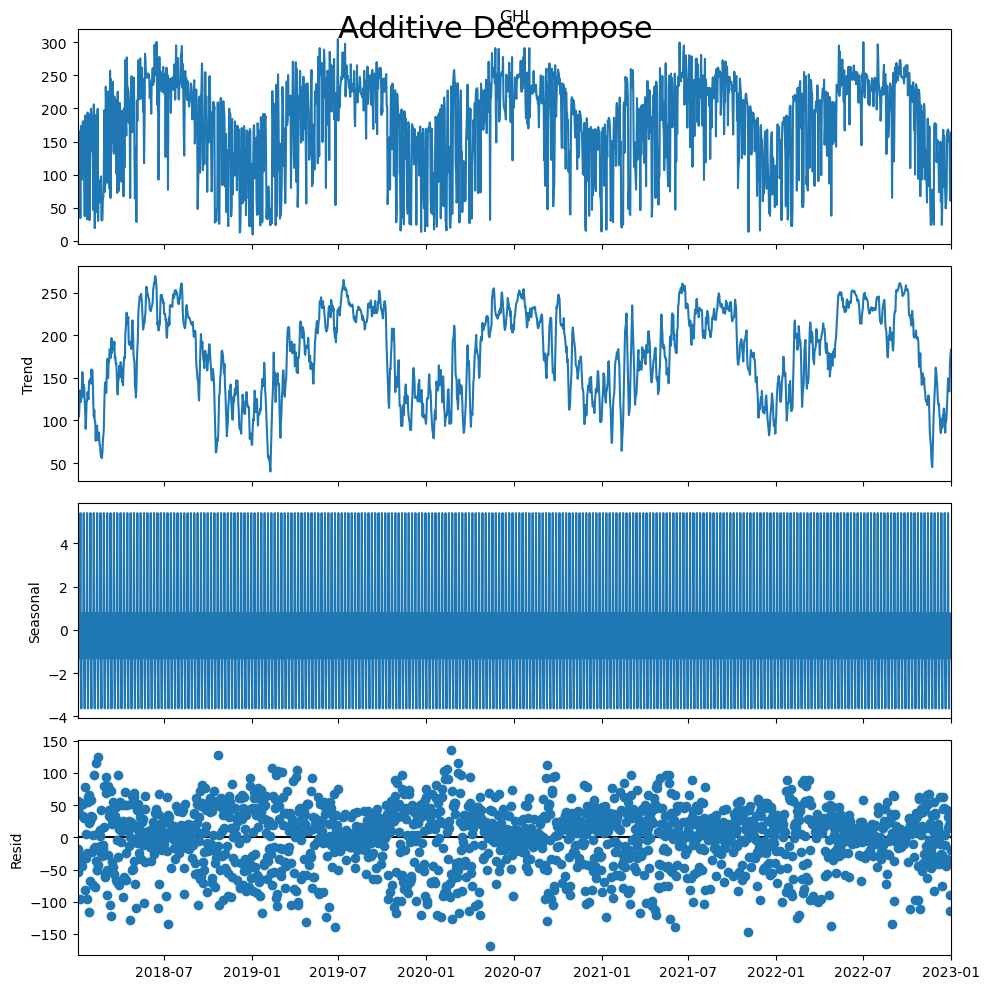

In [45]:
result_add.plot().suptitle("Additive Decompose", fontsize =22)
plt.show()

In [46]:
result_mul = seasonal_decompose(df['GHI'], model='multiplicative', extrapolate_trend='freq')

Text(0.5, 0.98, 'Multiplicative Decompose')

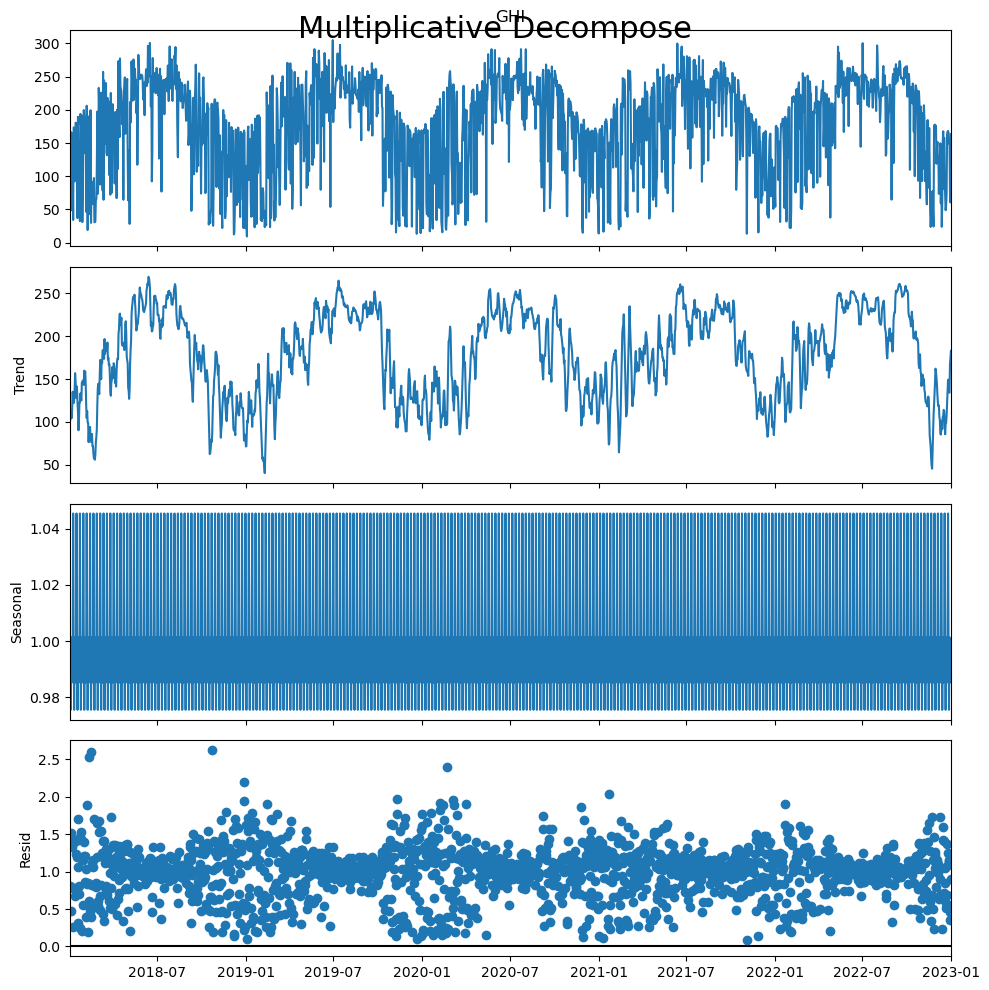

In [47]:
result_mul.plot().suptitle("Multiplicative Decompose", fontsize =22)

In [48]:
series = df["GHI"]

In [49]:
historic = series.iloc[:int(len(series)*0.7)]

In [50]:
test =series.iloc[int(len(series)*0.7):]

In [51]:
historic = historic.to_list ()

In [52]:
predictions = []
for i in range (len ( test )):
    sel = ar_select_order ( historic , 13 , old_names = False )
    sel . ar_lags
    model_fit = sel . model .fit ()
    pred = model_fit . predict ( start = len ( historic ), end = len ( historic ),dynamic = False )
    predictions . append ( pred [0])
    historic . append ( test [i])

In [53]:
cross_val = pd.Series(predictions , index = test.index )

In [54]:
test_score = mean_squared_error (test , cross_val , squared = False)

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
RForest_clf = RandomForestClassifier(n_estimators = 100)
RForest_clf.fit(X_train, y_train)
y_pred = RForest_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)*100
print(f'Accuracy: {accuracy}')

Accuracy: 42.38911886457718


In [62]:
print(test_score)

46.439593513267454


In [63]:
historic = series

In [64]:
n_pred = 365

In [65]:
date_pred = pd. date_range ("2023 -01 -01" , periods = n_pred , freq ="D")

In [66]:
sel = ar_select_order(historic , 13 , glob = True , seasonal = True ,old_names = False)

In [67]:
sel.ar_lags

[1, 4, 6, 8, 12, 13]

In [68]:
model_fit = sel.model.fit()

In [69]:
pred = model_fit.predict (start =len(historic), end =len(historic) + n_pred - 1 , dynamic = False)

In [70]:
predictions = pd. Series(pred .values , index = date_pred)

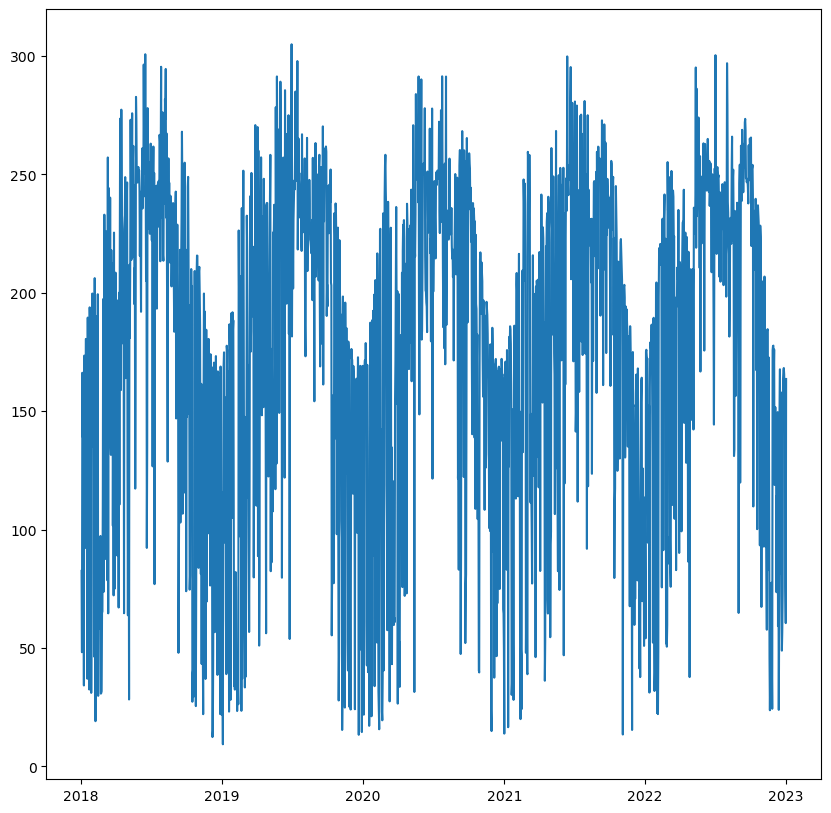

In [71]:
plt.plot(series , label = "Observed")
plt.show()

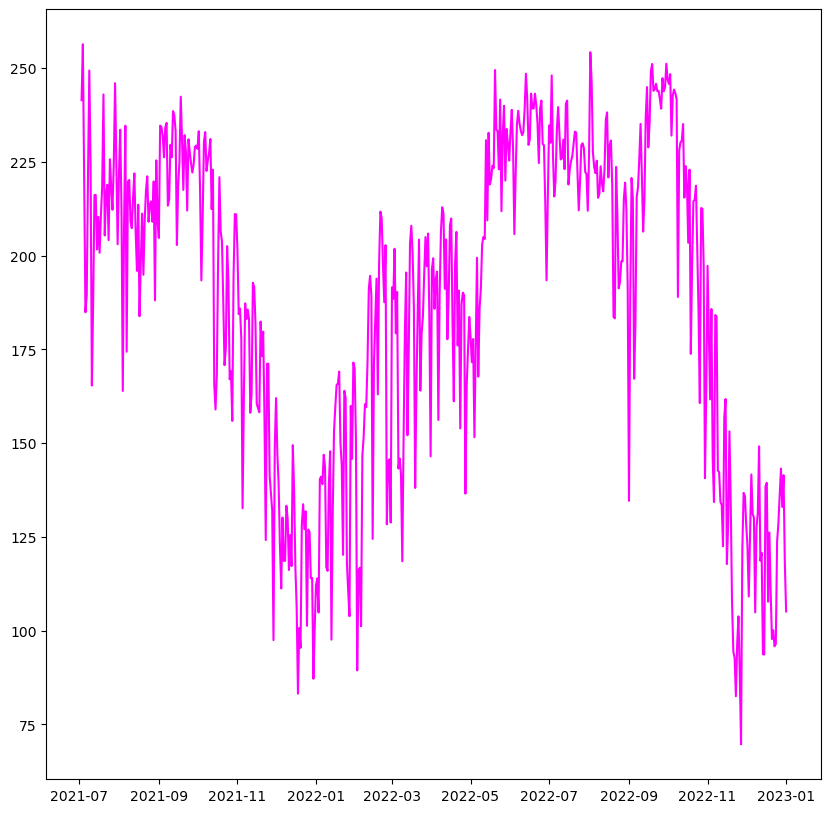

In [72]:
plt.plot(cross_val , color ="magenta", label = "Cross Validation")
plt.show()

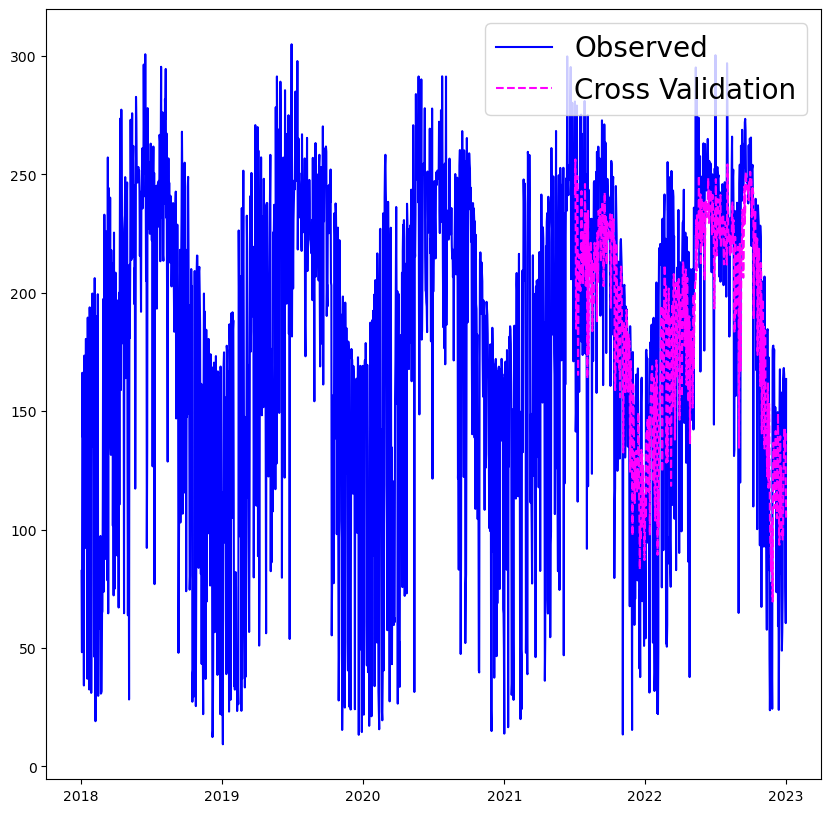

In [73]:
plt.plot(series, label='Observed', color='blue', linestyle='-')
plt.plot(cross_val, label='Cross Validation', color='magenta', linestyle='--')
plt.legend(fontsize=20)
plt.show()

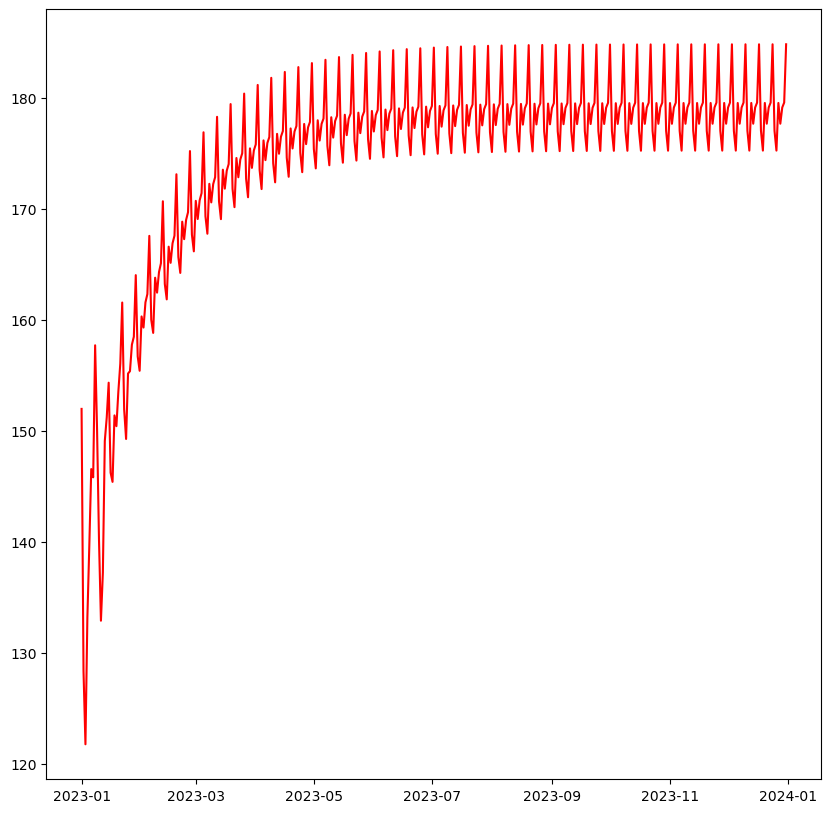

In [74]:
plt.plot(predictions , color = "red", label ="Predicted")
plt.show()

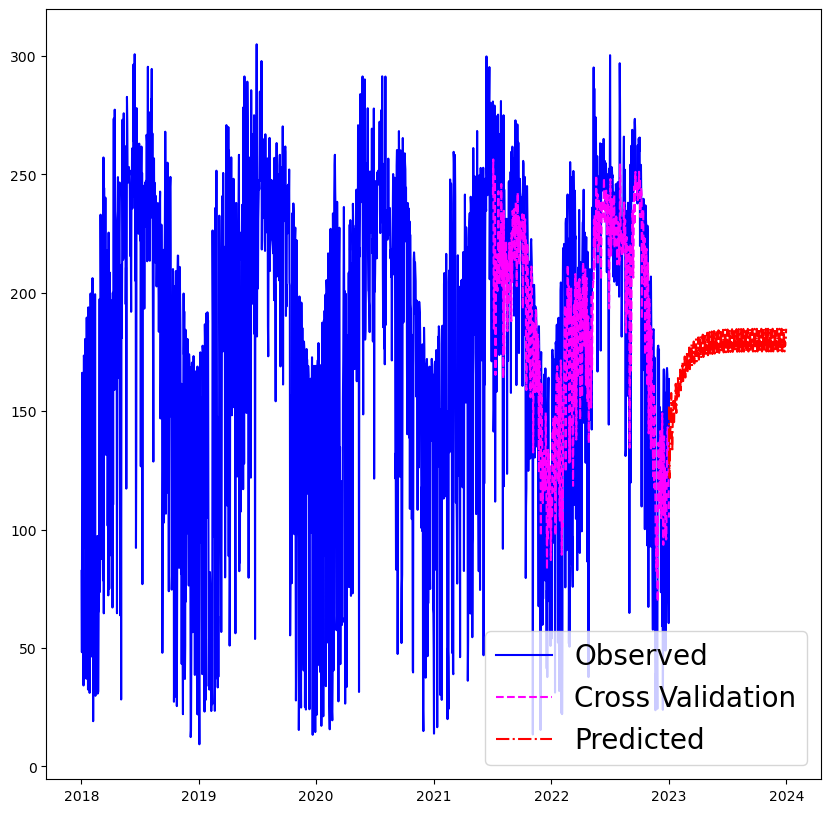

In [75]:
plt.plot(series, label='Observed', color='blue', linestyle='-')
plt.plot(cross_val, label='Cross Validation', color='magenta', linestyle='--')
plt.plot(predictions, label='Predicted', color='red', linestyle='-.')
plt.legend(fontsize=20)
plt.show()